In [1]:
import os

import pycisTopic
import scanpy as sc

#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

# set paths
work_dir = '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART'
data_dir = '/Scottbrowne/seq/tmp/devoes/SD031'
tmp_dir =  '/scratch2/devoes/tmp/'
fragments_dict = {
    #"MA025_tr1_B16_TILs" : os.path.join(data_dir,'MA025/tr1/cellranger-arc_outs/MA025_multiome_tr1/outs/atac_fragments.tsv.gz'),
    #"MA025_tr2_B16_TILs" : os.path.join(data_dir,'MA025/tr2/cellranger-arc_outs/MA025_multiome_tr2/outs/atac_fragments.tsv.gz'),
    #"GSE222346_LCMVcl13" : os.path.join(data_dir,'GSE222346/cellranger-arc_outs/GSE222346_LCMVcl13/outs/atac_fragments.tsv.gz'),
    #"GSE202543_E2APBX1_CART_spleen" : os.path.join(data_dir,'GSE202543/E2APBX1_CAR_T_D7_Spleen/cellranger-arc_outs/GSE202543_E2APBX1_CAR_T_D7_Spleen/outs/atac_fragments.tsv.gz'), # should we remove this sample since we don't have this cancer in our in vivo data?
    "GSE202543_B16_CART_tumor" : os.path.join(data_dir,'GSE202543/B16_CAR_T_D7_Tumor/cellranger-arc_outs/GSE202543_B16_CAR_T_D7_Tumor/outs/atac_fragments.tsv.gz')
} 
macs_path='/home/devoes/miniconda3/envs/SCENICplus_SCA/bin/macs2'
path_to_blacklist= '/Scottbrowne/members/smd/genomes/mm10/ENCODE_blacklist/mm10-blacklist.v2.bed.gz'

if not os.path.exists(os.path.join(work_dir, 'ATAC')):
    os.makedirs(os.path.join(work_dir, 'ATAC'))

In [2]:
# obtain cluster annotations from GEX
adata = sc.read_h5ad(os.path.join(work_dir, 'RNA/adata_SCA.h5ad'))

In [3]:
cell_data = adata.obs
cell_data['sample_id'] = 'GSE202543_B16_CART_tumor'
cell_data['leiden'] = cell_data['leiden'].astype(str) # set data type of the leiden cluster column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [4]:
# Get chromosome sizes 
import pyranges as pr
import requests
import pandas as pd

chr_sizes_file='/Scottbrowne/members/smd/genomes/refdata-cellranger-arc-mm10-2020-A-2.0.0.chr.sizes'
chromsizes=pd.read_csv(chr_sizes_file, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
# put in bed format
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]

# Change formatting/nomenclature to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
# filter non-standard assemblies
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [5]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
# Generate pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'leiden',    # variable by which to generate pseubulk profiles
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'ATAC/consensus_peak_calling/pseudobulk_bed_files/'), 
                 bigwig_path = os.path.join(work_dir, 'ATAC/consensus_peak_calling/pseudobulk_bw_files/'),
                 path_to_fragments = fragments_dict,                                                        
                 n_cpu = 1,           
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'), # file path can't be too long or it throws an error
                 split_pattern = '-')

2024-06-01 07:14:02,404 cisTopic     INFO     Reading fragments from /Scottbrowne/seq/tmp/devoes/SD031/GSE202543/B16_CAR_T_D7_Tumor/cellranger-arc_outs/GSE202543_B16_CAR_T_D7_Tumor/outs/atac_fragments.tsv.gz
2024-06-01 07:20:26,794 cisTopic     INFO     Creating pseudobulk for 0
2024-06-01 07:33:15,090 cisTopic     INFO     0 done!
2024-06-01 07:33:15,094 cisTopic     INFO     Creating pseudobulk for 1
2024-06-01 07:48:23,614 cisTopic     INFO     1 done!
2024-06-01 07:48:23,617 cisTopic     INFO     Creating pseudobulk for 10
2024-06-01 07:49:52,154 cisTopic     INFO     10 done!
2024-06-01 07:49:52,156 cisTopic     INFO     Creating pseudobulk for 11
2024-06-01 07:52:25,368 cisTopic     INFO     11 done!
2024-06-01 07:52:25,370 cisTopic     INFO     Creating pseudobulk for 12
2024-06-01 07:53:27,826 cisTopic     INFO     12 done!
2024-06-01 07:53:27,828 cisTopic     INFO     Creating pseudobulk for 13
2024-06-01 07:54:34,365 cisTopic     INFO     13 done!
2024-06-01 07:54:34,366 cisT

In [6]:
# save files
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'ATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'ATAC/consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl'), 'wb'))

In [7]:
# call peaks on clusters

# import pickle - already imported
bed_paths = pickle.load(open(os.path.join(work_dir, 'ATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'ATAC/consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl'), 'rb'))

from pycisTopic.pseudobulk_peak_calling import peak_calling
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'ATAC/consensus_peak_calling/MACS/'),
                                 genome_size='mm',
                                 n_cpu=1,
                                 input_format='BEDPE',
                                 shift = -73, #### NOTE: tutorial for SCENIC+ and pycistopic have a + shift, macs2 says to do - unless there is something I dont understand
                                 # isnt shift disabled for BAMPE and BEDPE? https://macs3-project.github.io/MACS/docs/callpeak.html
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 nolambda = True,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2024-06-01 10:34:43,318 cisTopic     INFO     Calling peaks for 0 with /home/devoes/miniconda3/envs/SCENICplus_SCA/bin/macs2 callpeak --treatment /Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/0.bed.gz --name 0  --outdir /Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize mm --qvalue 0.05 --nomodel --shift -73 --extsize 146 --keep-dup all --call-summits --nolambda
2024-06-01 10:39:42,249 cisTopic     INFO     0 done!
2024-06-01 10:39:42,251 cisTopic     INFO     Calling peaks for 1 with /home/devoes/miniconda3/envs/SCENICplus_SCA/bin/macs2 callpeak --treatment /Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/1.bed.gz --name 1  --outdir /Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize mm --qvalue 0.05 --nomodel --shift -73 --extsize 146

In [8]:
bed_paths

{'0': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/0.bed.gz',
 '1': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/1.bed.gz',
 '10': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/10.bed.gz',
 '11': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/11.bed.gz',
 '12': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/12.bed.gz',
 '13': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/13.bed.gz',
 '14': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudobulk_bed_files/14.bed.gz',
 '2': '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART/ATAC/consensus_peak_calling/pseudo

In [10]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, 'ATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [11]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 150 # match halfwidth of in vivo GV
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2024-06-01 11:20:14,720 cisTopic     INFO     Extending and merging peaks per class
2024-06-01 11:22:40,084 cisTopic     INFO     Normalizing peak scores
2024-06-01 11:22:41,035 cisTopic     INFO     Merging peaks
2024-06-01 11:24:34,948 cisTopic     INFO     Done!


In [12]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'ATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

In [13]:
import pybiomart as pbm
dataset = pbm.Dataset(name='mmusculus_gene_ensembl', host='http://nov2020.archive.ensembl.org/') # used mm10 (version 102) # host='http://www.ensembl.org' is mm39
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)

# remove non-standard assembly
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter] # tilde is negate in python

# correct nomenclature
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(^[XYM0-9]+)',r'chr\1') # change from athena 
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
#annot['Chromosome'].value_counts()

/tmp/ipykernel_3486/2010435910.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(^[XYM0-9]+)',r'chr\1') # change from athena


In [14]:
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'GSE202543_B16_CART_tumor':os.path.join(work_dir, 'ATAC/consensus_peak_calling/consensus_regions.bed')}

In [15]:
metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 4,
                valid_bc = None,
                partitions = 5,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                check_for_duplicates = False,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'ATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'ATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'ATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'ATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2024-06-01 12:31:23,305 cisTopic     INFO     n_cpu is larger than the number of samples. Setting n_cpu to the number of samples
2024-06-01 12:31:23,307 cisTopic     INFO     Reading GSE202543_B16_CART_tumor
2024-06-01 12:37:17,167 cisTopic     INFO     Computing barcode rank plot for GSE202543_B16_CART_tumor
2024-06-01 12:37:17,168 cisTopic     INFO     Counting fragments
2024-06-01 12:37:29,663 cisTopic     INFO     Marking barcodes with more than 100
2024-06-01 12:37:29,766 cisTopic     INFO     Returning plot data
2024-06-01 12:37:29,772 cisTopic     INFO     Returning valid barcodes
2024-06-01 12:37:44,213 cisTopic     INFO     Computing duplicate rate plot for GSE202543_B16_CART_tumor
2024-06-01 12:38:02,258 cisTopic     INFO     Return plot data
2024-06-01 12:38:02,411 cisTopic     INFO     Computing insert size distribution for GSE202543_B16_CART_tumor
2024-06-01 12:38:02,412 cisTopic     INFO     Counting fragments
2024-06-01 12:38:09,040 cisTopic     INFO     Returning plot d

In [24]:
# set QC Filter metrics dictionary
QC_filters = {
    'Log_unique_nr_frag': [3.6 , None], # approx 4000
    'FRIP':               [0.35, None], 
    'TSS_enrichment':     [6   , None],
    'Dupl_rate':          [None, 0.45]
}

/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/python3.10/site-packages/pycisTopic/qc.py:1876: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/python3.10/site-packages/pycisTopic/qc.py:1891: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.


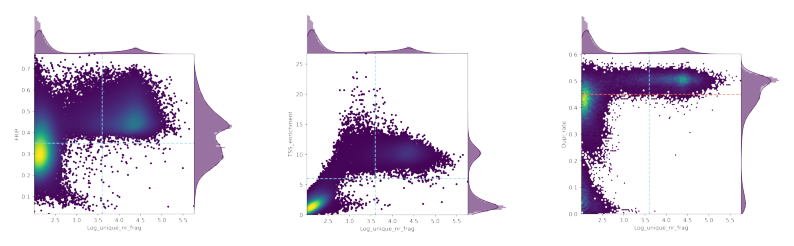

In [25]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['GSE202543_B16_CART_tumor'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['GSE202543_B16_CART_tumor'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['GSE202543_B16_CART_tumor'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
bc_passing_filters = {'GSE202543_B16_CART_tumor':[]}
bc_passing_filters['GSE202543_B16_CART_tumor'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'ATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['GSE202543_B16_CART_tumor'])} barcodes passed QC stats")

14775 barcodes passed QC stats
